# Analyzing mask data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob
import re
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from time import time
import math

In [2]:
# constants

data = '/kaggle/dev/data-science-bowl-2017-data/'
stage1 = '/kaggle/dev/data-science-bowl-2017-data/stage1/'
sample_images = '/kaggle/dev/data-science-bowl-2017-data/sample_images/'
labels = '/kaggle/dev/data-science-bowl-2017-data/stage1_labels.csv'
stage1_processed = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
stage1_features = '/kaggle/dev/data-science-bowl-2017-data/stage1_features_mx/'
stage1_submission = '/kaggle/dev/data-science-bowl-2017-data/stage1_sample_submission.csv'
naive_submission = '/kaggle/dev/jovan/data-science-bowl-2017/data-science-bowl-2017/submissions/naive_submission.csv'

## Setup

In [3]:
sample_ids = []

for d in os.listdir(sample_images):
    sample_ids.append(d)
    print("Patient '{}' has {} scans".format(d, len(os.listdir(sample_images + d))))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(stage1)), 
                                                      len(glob.glob(stage1 + '*/*.dcm'))))

Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0d2fcf787026fece4e57be167d079383' has 126 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0d941a3ad6c889ac451caf89c46cb92a' has 177 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0c0de3749d4fe175b7a5098b060982a1' has 123 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0de72529c30fe642bc60dcb75c87f6bd' has 113 scans
Patient '0ddeb08e9c97227853422bd71a2a695e' has 171 scans
Patient '0a099f2549429d29b32f34

In [44]:
print("Analysis will be done on:")
num_patients = 20 # number of patients to analyze
scan_segmented_lungs_fill = []
scan_segmented_lungs = []

for folder in glob.glob(stage1_processed + 'scan_segmented_lungs_fill_*'):
    m = re.match(r'scan_segmented_lungs_fill_([a-f0-9].*).npy', os.path.basename(folder))
    if(m.group(1) in sample_ids[0:num_patients]):
        x = np.load(stage1_processed + m.group(0))
        y = np.load(stage1_processed + "scan_segmented_lungs_" + str(m.group(1)) + ".npy" )
        scan_segmented_lungs_fill.append(x)
        scan_segmented_lungs.append(y)
        print('Patient {}: array shape: {}'.format(m.group(1), x.shape))

Analysis will be done on:
Patient 0a0c32c9e08cc2ea76a71649de56be6d: array shape: (332, 340, 340)
Patient 0bd0e3056cbf23a1cb7f0f0b18446068: array shape: (350, 340, 340)
Patient 0c0de3749d4fe175b7a5098b060982a1: array shape: (308, 355, 355)
Patient 0acbebb8d463b4b9ca88cf38431aac69: array shape: (365, 279, 279)
Patient 0c9d8314f9c69840e25febabb1229fa4: array shape: (398, 309, 309)
Patient 0de72529c30fe642bc60dcb75c87f6bd: array shape: (282, 308, 308)
Patient 0d19f1c627df49eb223771c28548350e: array shape: (366, 370, 370)
Patient 0d2fcf787026fece4e57be167d079383: array shape: (315, 310, 310)
Patient 0c60f4b87afcb3e2dfa65abbbf3ef2f9: array shape: (272, 330, 330)
Patient 00cba091fa4ad62cc3200a657aeb957e: array shape: (335, 306, 306)
Patient 0c37613214faddf8701ca41e6d43f56e: array shape: (328, 360, 360)
Patient 0a38e7597ca26f9374f8ea2770ba870d: array shape: (275, 320, 320)
Patient 0d941a3ad6c889ac451caf89c46cb92a: array shape: (354, 259, 259)
Patient 0c98fcb55e3f36d0c2b6507f62f4c5f1: array sha

## Plotting

Let's plot one patient (patient[0]) to see what the data looks like

In [48]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
#     ax.invert_zaxis()


    plt.show()

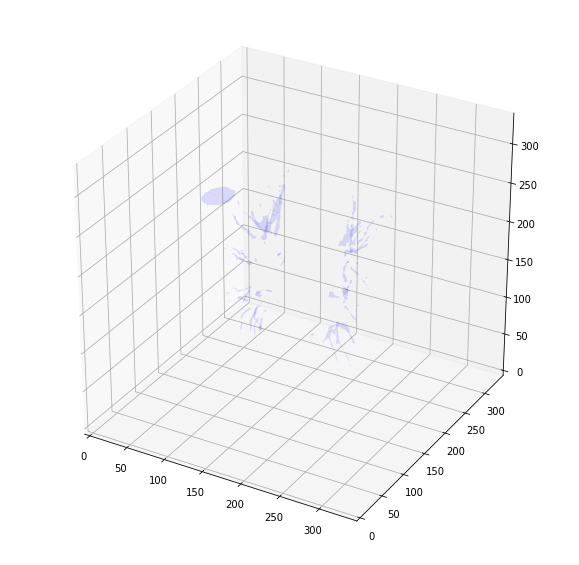

In [49]:
plot_3d(scan_segmented_lungs_fill[0], 0)